# Spatial transcriptomics unveils the in situ cellular and molecular hallmarks of the lung in fatal COVID-19

# Spatial dependencies as a function of niche composition across COVID-19 induced DAD progression

**Author:** Carlos A. Garcia-Prieto

* This notebook explains the type coupling analysis for deconvoluted Visium ST data to identify spatial intercellular dependencies as a function of spot composition using [NCEM](https://ncem.readthedocs.io/en/latest).
* We followed type coupling analysis [tutorial.](https://github.com/theislab/ncem_tutorials/blob/main/tutorials/type_coupling_visium.ipynb)

## Import modules

In [1]:
import warnings
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2
import sys
import os
import ncem as nc
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import squidpy as sq
import pandas as pd
from ncem.interpretation import InterpreterDeconvolution
from ncem.train import TrainModelLinearDeconvolution
from ncem.data import get_data_custom, customLoaderDeconvolution

2024-07-16 20:47:11.764016: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-16 20:47:18.278342: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Path to "pseudo" single-cell resolved anndata
The folder should contain an annData object that was deconvoluted with cell2location and save as "pseudo" single-cell file

In [2]:
#Set data directories
ncem_folder = "/mnt/beegfs/cgarcia/Spatial/COVID19/cell2location/HLCA_publication/HLCA/ncem"
results_folder = "/mnt/beegfs/cgarcia/Spatial/COVID19/cell2location/HLCA_publication/HLCA"
ref_run_name = f'{results_folder}reference_signatures_finest'
run_name = f'{results_folder}cell2location_map_finest'

In [3]:
#Read data
adata_file = f"{ncem_folder}/Celltype22_Markers_Wiki_1614/cell2location_ad_vis_finest_ncem_HUGO_scCODA_22_filter_celltype_markers_Wiki_1614_Paper.h5ad"
adata = sc.read_h5ad(adata_file)

In [4]:
#List samples by condition
covid19_proliferative = ["L2P","L19P","L11P","HRC5","HRC6","HRC8","HRC10","HRC11","HRC12","HRC13","HRC16","HRC17"]
covid19_acute = ["L5P","L14P","L24P","L12P","HRC2","HRC4","HRC18"]
controls = ["L3C","L14C","L2C","CONTROL2"]

In [5]:
adata_ctl = adata[adata.obs['sample'].isin(controls)]

In [6]:
adata_covid_acute = adata[adata.obs['sample'].isin(covid19_acute)]

In [7]:
adata_covid_proliferative = adata[adata.obs['sample'].isin(covid19_proliferative)]

## Initialize ncem model for deconvoluted Visium
Repeat initialization for controls, acute DAD and proliferative DAD

In [8]:
ncem_ip = InterpreterDeconvolution()

In [9]:
#Repeat for adata_ctl, adata_covid_acute and adata_covid_proliferative
ncem_ip.data = customLoaderDeconvolution(
    adata=adata_covid_proliferative, patient='sample', library_id='sample', radius=None,
)

Loading data from raw files
registering celldata
collecting image-wise celldata
adding graph-level covariates


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:24<00:00,  2.03s/it]

Loaded 12 images with complete data from 12 patients over 1091838 cells with 1614 cell features and 22 distinct celltypes.


In [10]:
get_data_custom(interpreter=ncem_ip, deconvolution=True)

Mean of mean node degree per images across images: 6.000000
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 1091838 cells out of 12 images from 12 patients.
Test dataset: 109184 cells out of 12 images from 12 patients.
Training dataset: 889243 cells out of 12 images from 12 patients.
Validation dataset: 98267 cells out of 12 images from 12 patients. 



## Type coupling analysis

In [11]:
ncem_ip.get_sender_receiver_effects()

using ols parameters.
calculating inv fim.


In [12]:
#Set disease status
status = "proliferative" #acute;control

In [13]:
#Create directory to save results
directory = f'{ncem_folder}/Celltype22_Markers_Wiki_1614/{status}'
# Check if the directory exists
if not os.path.exists(directory):
    # If it doesn't exist, create it
    os.makedirs(directory)

## Plot type coupling analysis results

<div class="alert alert-info">
<b>Paper Figure!</b>
Panel Figure 5A
</div>

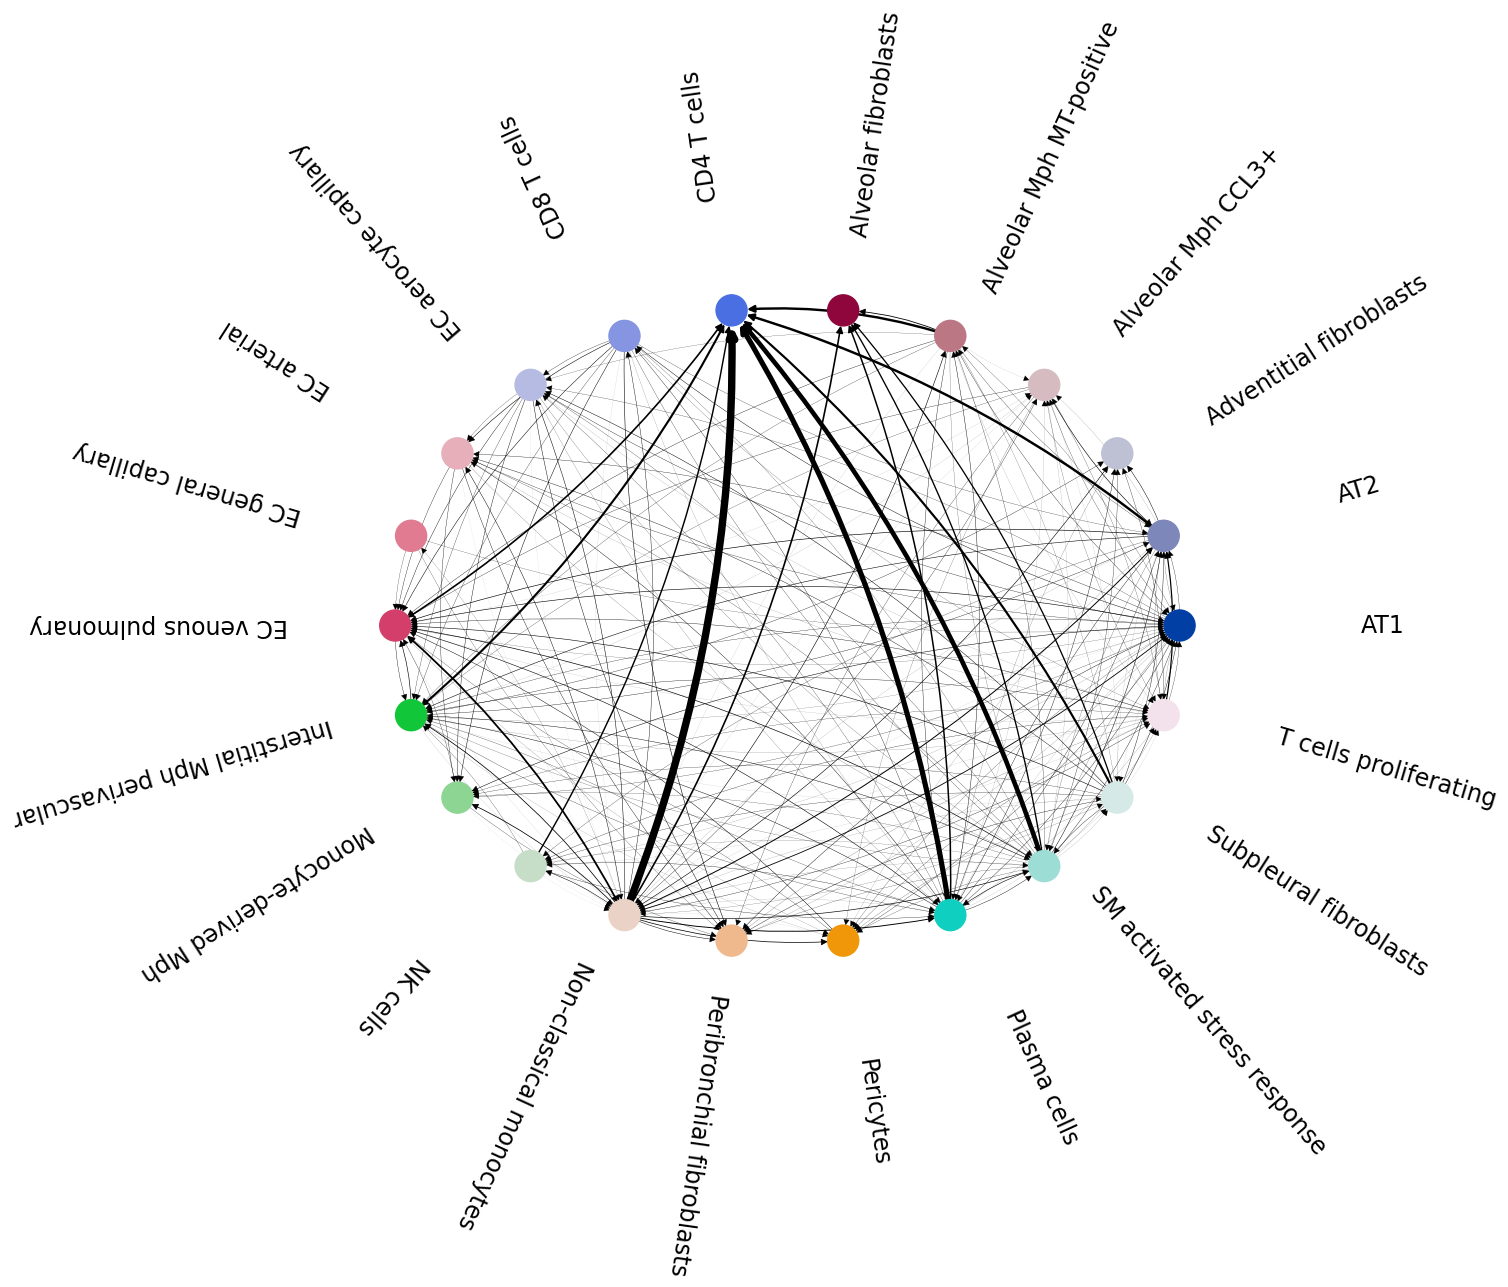

In [14]:
#Type coupling analysis with at least 500 differentially expressed genes
type_coupling = ncem_ip.type_coupling_analysis_circular(
    edge_attr='magnitude', figsize=(16,14), edge_width_scale= 0.6, text_space=1.5, de_genes_threshold=500, save = f"{ncem_folder}/", suffix=f"{status}_cell_type_coupling_magnitude500threshold_Paper.pdf"
)

## Putative sender-receiver dependencies
We can now dissect these couplings based on the gene-wise effects of one particular interaction (select a different interaction according to disease status)

In [15]:
#Set sender and receiver cell types
sender = "Non-classical monocytes" #CD8 T cells for controls; AT1 cells for acute DAD
receiver = "CD4 T cells" #NK cells for controls; CD4 T cells for acute DAD

In [16]:
effect_df = ncem_ip.sender_receiver_values(sender=f'{sender}', receiver=f'{receiver}')

In [17]:
#Write results
effect_df.to_csv(f"{ncem_folder}/effect_{sender}_on_{receiver}_{status}_Paper.csv", index=True)

In [18]:
#Select statistically and biologically meaningful genes
gene_subset = effect_df[effect_df['qvalue'] < 0.05].index

In [19]:
gene_subset = effect_df[abs(effect_df['fold change']) > 0.8].index

## Plot sender effect analysis results

<div class="alert alert-info">
<b>Paper Figure!</b>
Panel Figure 5B
</div>

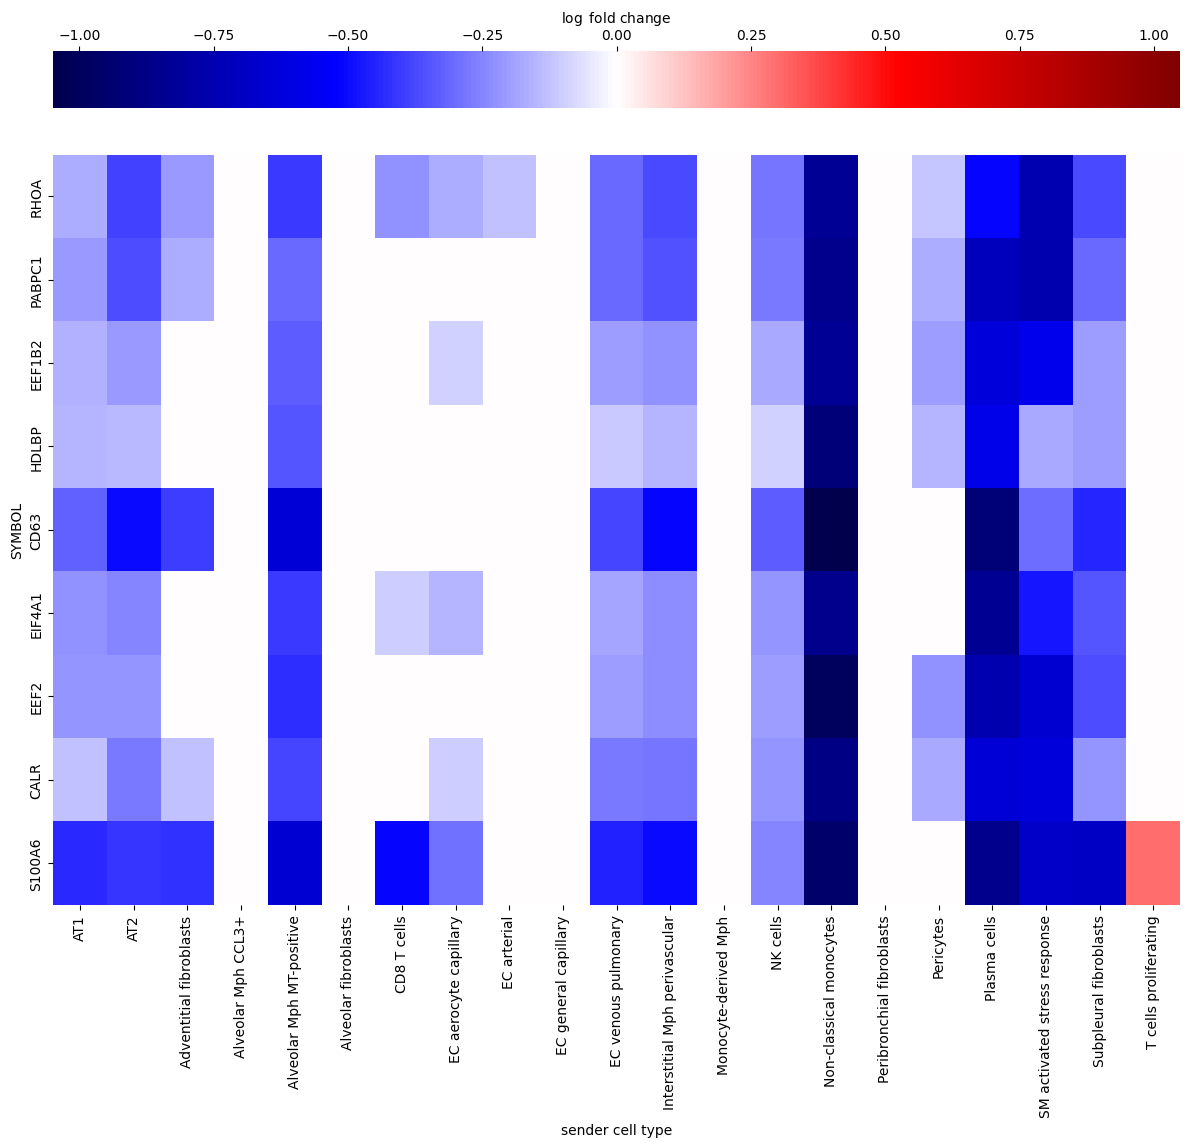

In [20]:
ncem_ip.sender_effect(receiver=f'{receiver}', gene_subset=list(gene_subset), figsize=(12,12), save = f"{ncem_folder}/", suffix=f"{status}_cell_type_sender_effect_{sender}_receiver_{receiver}_lfc08_Paper.pdf")

# Sender similarity analysis for CD4 T cells
“Sender similarity analysis” of all sender cell types with respect to CD4 T cell receivers (repeat for controls, acute DAD and proliferative DAD samples)

<div class="alert alert-info">
<b>Paper Figure!</b>
Panel Figure 5B
</div>

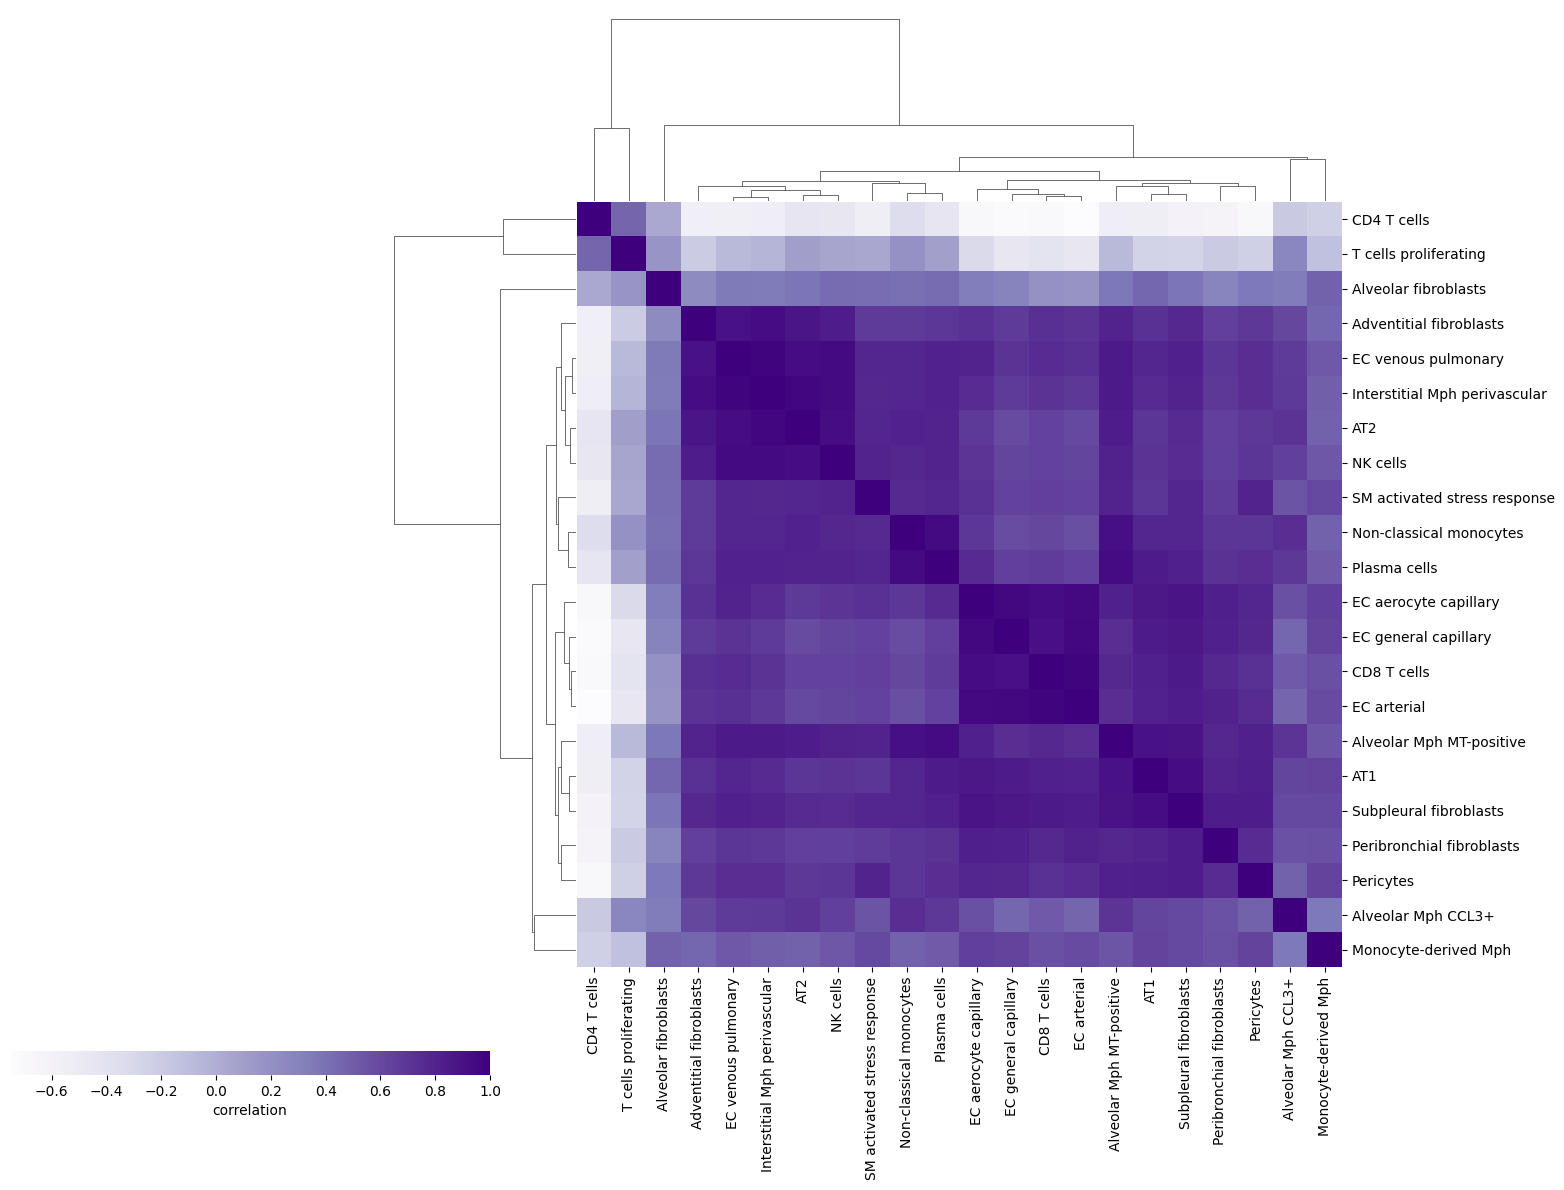

In [21]:
ncem_ip.sender_similarity_analysis(receiver=f'{receiver}', figsize=(12,12), save = f"{ncem_folder}/", suffix=f"{status}_cell_type_sender_similarity_receiver_{receiver}_Paper.png")
